# Gradient boosting optimization using FLAML

Using the tips dataset
https://microsoft.github.io/FLAML/docs/Examples/AutoML-for-LightGBM/

## Setup libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np

In [4]:
import sys

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.metrics import mean_squared_error

In [7]:
import lightgbm as lgb

In [8]:
import matplotlib.pyplot as plt

In [9]:
from flaml import AutoML

In [10]:
warnings.simplefilter("ignore")

## Utility functions

In [11]:
def get_model_predict(model, X_test):
    if isinstance(model, lgb.engine.CVBooster):
        if model.best_iteration > 0:
            y_pred_list = model.predict(
                X_test, num_iteration=model.best_iteration
            )
        else:
            y_pred_list = model.predict(X_test)
        y_pred = np.mean(np.asarray(y_pred_list), axis=0)
    else:
        y_pred = model.predict(X_test)
    return y_pred

In [12]:
def print_mse_performance(model, X_test, y_test, name):
    'display mean-squared-error for fitted model'

    y_pred = get_model_predict(model, X_test)
    mse = mean_squared_error(y_test, y_pred)
    model_name = model.__class__.__name__
    print('{}, {}, mse = {:.2f}'.format(model_name, name, mse))

In [13]:
def plot_actual_predict(actual, predict, ax, title):
    'plot actual label vs predicted label'
    model_predict = pd.DataFrame(
        {'actual': actual, 'predict': predict, 'residual': predict - actual}
    )
    ax = sns.scatterplot(x='actual', y='predict', data=model_predict, ax=ax)
    (xmin, xmax), (ymin, ymax) = [ax.get_xlim(), ax.get_ylim()]
    min_axis, max_axis = min(xmin, ymin), max(xmax, ymax)
    ax.set_xlim(min_axis, max_axis)
    ax.set_ylim(min_axis, max_axis)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    ax.set_title(title)

In [14]:
def plot_actual_residual(actual, predict, ax, title):
    'plot actual label vs residual (predict - actual)'
    model_predict = pd.DataFrame(
        {'actual': actual, 'predict': predict, 'residual': predict - actual}
    )
    ax = sns.scatterplot(x='actual', y='residual', data=model_predict, ax=ax)
    ax.axhline(y=0, color='red', linestyle='dotted')
    ax.set_title(title)

In [15]:
def train_early_stopping_lgb(lgbm_params, lgb_train, lgb_eval):
    'train lightgbm model with early stopping'
    model = lgb.train(
        lgbm_params,
        lgb_train,
        valid_sets=lgb_eval,
        verbose_eval=-1,
        callbacks=[lgb.early_stopping(10, verbose=False)],
    )
    return model

In [16]:
def train_cv_lgb(lgbm_params, lgb_train):
    'train lightgbm model with cross validation'
    cv_model = lgb.cv(
        lgbm_params,
        lgb_train,
        nfold=3,
        stratified=False,
        verbose_eval=-1,
        return_cvbooster=True,
        callbacks=[lgb.early_stopping(10, verbose=False)],
    )
    return cv_model['cvbooster']

In [17]:
def l2_loss(y, data):
    t = data.get_label()
    grad = y - t
    hess = np.ones_like(y)
    return grad, hess

In [18]:
def l2_eval(y, data):
    t = data.get_label()
    loss = (y - t) ** 2
    return 'l2', loss.mean(), False

In [19]:
def train_custom_loss():
    _ = lgb.train(
        lgbm_params,
        lgb_train,
        valid_sets=lgb_eval,
        verbose_eval=-1,
        # fobj=l2_loss, feval=l2_eval,
        # callbacks=[lgb.early_stopping(10, verbose=False)],
    )

## Get data

In [52]:
raw_data = sns.load_dataset('tips')

In [53]:
raw_data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [54]:
raw_data.dtypes.value_counts()

float64     2
category    1
category    1
category    1
category    1
int64       1
dtype: int64

<AxesSubplot:xlabel='total_bill', ylabel='Count'>

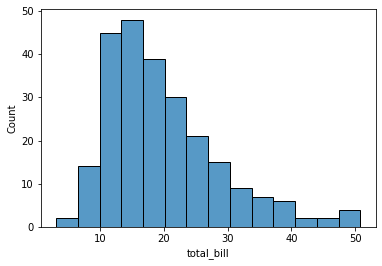

In [55]:
sns.histplot(raw_data.total_bill)

In [56]:
tips_data = raw_data

## Setup features, label

In [58]:
y = tips_data.total_bill
X = tips_data.drop(columns=['total_bill'])

Split data into train and test

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

## Train model

FLAML may not optimize hyperparameters with limited data

In [65]:
automl = AutoML()
settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'mse',
    "estimator_list": ['lgbm'],
    "task": 'regression',  # task type
    "log_file_name": 'tips_flaml_experiment.log',  # flaml log file
    "verbose": False
}
automl.fit(X_train=X_train, y_train=y_train, **settings)

In [66]:
# print results
print('Best hyperparmeter config:', automl.best_config)
print('Best mse on validation data: {0:.4g}'.format(automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(
    automl.best_config_train_time))
print(automl.model.estimator)

Best hyperparmeter config: {'n_estimators': 17, 'num_leaves': 4, 'min_child_samples': 11, 'learning_rate': 0.5074123471351436, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.004352443603487678, 'reg_lambda': 39.72682028858723}
Best mse on validation data: 41.97
Training duration of best run: 0.01607 s
LGBMRegressor(learning_rate=0.5074123471351436, max_bin=1023,
              min_child_samples=11, n_estimators=17, num_leaves=4,
              reg_alpha=0.004352443603487678, reg_lambda=39.72682028858723,
              verbose=-1)


In [67]:
y_pred = automl.predict(X_test)

In [68]:
mse = mean_squared_error(y_test, y_pred)
print('{}, mse = {:.2f}'.format('mse', mse))

mse, mse = 30.79


## Compare untuned lightgbm

In [76]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [79]:
lgbm_params = {'objective': 'regression_l2',
               'learning_rate': 0.5,
               'random_seed': 0, 'verbose': -1}
# gbm_l2 = train_early_stopping_lgb(lgbm_params, lgb_train, lgb_eval)
gbm_l2 = train_cv_lgb(lgbm_params, lgb_train)

In [80]:
print_mse_performance(gbm_l2, X_test, y_test, 'l2')

CVBooster, l2, mse = 26.23
